**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import saraRC1 as sara

In [2]:
def plot_heatmap(im, grid_size, name=None):
    '''
    Given an image im, this function plots the heatmap generated by SaRa for the given grid size.
    '''

    heatmap, _ = sara.return_sara(cv2.imread(im), grid_size)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.figure(name + ' SaRa Output - Grid Size ' +
               str(grid_size) + ' x ' + str(grid_size))
    plt.gcf().set_size_inches(12, 6)
    plt.imshow(heatmap)
    plt.xticks([])
    plt.yticks([])
    plt.title('SaRa Output - Grid Size ' +
              str(grid_size) + ' x ' + str(grid_size))


In [3]:
def plot_score_vs_grid_size(scores, name=None, do='score'):
    '''
    Given a dictionary of scores, this function plots the average score vs grid size.
    '''

    plt.figure(name + ' Average Score vs Grid Size (Logarithmic Scale)')
    for seg_dim in scores.keys():
        plt.plot(seg_dim, scores[seg_dim][1], 'bo')
        if seg_dim > 5:
            plt.plot([seg_dim - 1, seg_dim], [scores[seg_dim - 1][1], scores[seg_dim][1]], 'k-')
        plt.grid(True)

    plt.xlabel('Grid Size')
    plt.ylabel('Average Score (Top 25% Segments)')
    plt.title('Average Score vs Grid Size (Logarithmic Scale)')
    plt.yscale('log')

    plt.gcf().set_size_inches(12, 6)
    plt.show()


In [4]:
def display_top_4_grids(scores, name):
    '''
    Given a dictionary of scores, this function plots the top 4 grids which maximise average score.
    '''

    plt.figure(name + ' SaRa Output - Top 4 Grid Sizes')
    plt.gcf().set_size_inches(12, 6)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        im = cv2.imread(scores[i][1][3])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(scores[i][1][0]) +
                  ' x ' + str(scores[i][1][0]))
    

**Experiment 1** – Average Entropy Maximisation

In [5]:
def maximise_entropy(im, name, n):
    '''
    Given an image im, this function returns the grid size that maximises the average score of the top n segments generated by SaRa.
    '''

    scores = {}
    s1 = cv2.imread(im)

    # All grid sizes
    plt.figure(name + ' SaRa Output - All Grid Sizes')
    plt.gcf().set_size_inches(12, 6)

    for seg_dim in range(5, n):
        heatmap, sara_list = sara.return_sara(s1.copy(), seg_dim)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Plot heatmap of grid size i x i
        plt.subplot(4, 5, seg_dim - 4)
        plt.imshow(heatmap)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(seg_dim) + ' x ' + str(seg_dim))

        # Output heatmap to file
        path = './output/' + name + \
            ' (' + str(seg_dim) + 'x' + str(seg_dim) + ').png'
        # heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
        # cv2.imwrite(path, heatmap)
        # print(f'Image saved to {path}')

        # Average entropy of the top 25% grid segments
        top = seg_dim * seg_dim // 4
        average = sum(sara_list[0:top][2]) / len(sara_list[0:top][2])
        scores[seg_dim] = (seg_dim, average, sara_list, path)

        sara.reset()

    scores_sorted = scores.copy()
    scores_sorted = sorted(scores_sorted.items(),
                              key=lambda x: x[1][1], reverse=True)

    return scores, scores_sorted


In [20]:
n = 25

path = '../images/'
name = 'cat.jpg'

im = path + name
img = cv2.imread(im)
img = cv2.resize(img, (0, 0), fx=0.3, fy=0.3)

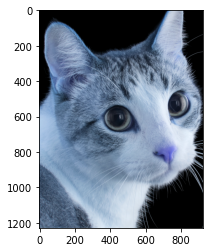

In [7]:
plt.imshow(img)

In [21]:
saliency_map = sara.return_saliency(img, generator='deepgaze')

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0


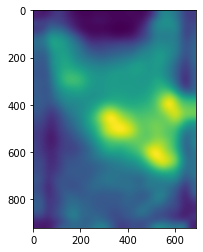

In [22]:
plt.imshow(saliency_map)

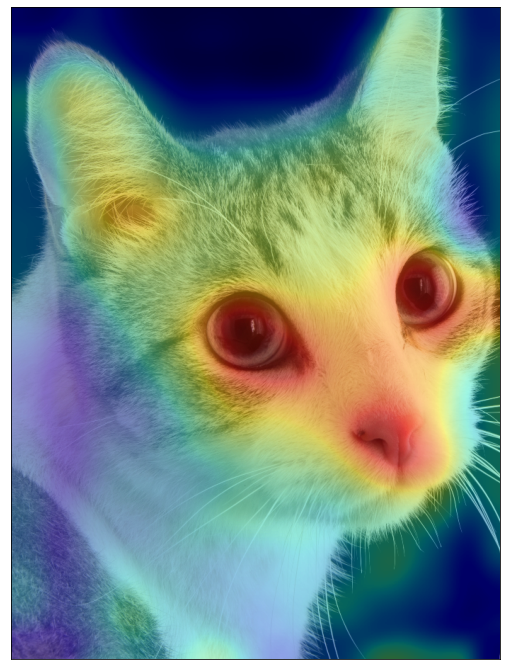

In [23]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(saliency_map, alpha=0.4, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

In [68]:
GRID_SIZE = 9 
sara.WEIGHTS = (1, 1.5, 0, 2)
im_bigger = img.copy()
sara_heatmap, sara_list = sara.return_sara(img.copy(), GRID_SIZE, saliency_map=saliency_map)
sara_heatmap = cv2.cvtColor(sara_heatmap, cv2.COLOR_BGR2RGB)
sara.reset()

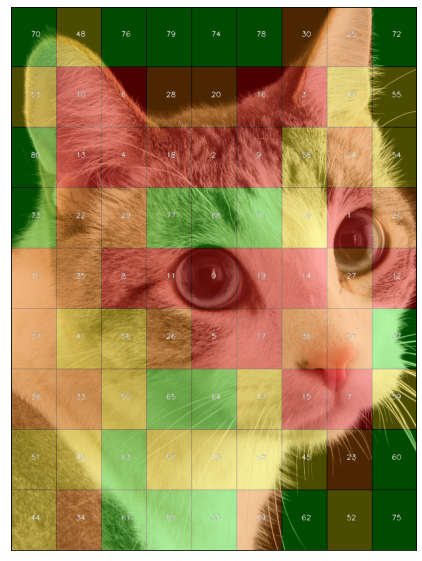

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(sara_heatmap)
plt.xticks([]), plt.yticks([])
plt.show()

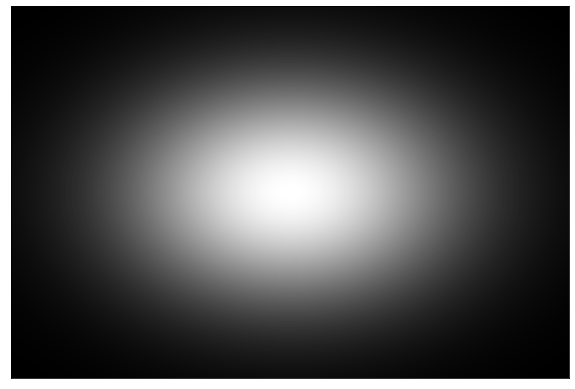

In [92]:
# Create a 512x512 image of agaussian kernel
kernel = cv2.getGaussianKernel(512, 106)
kernel = kernel * kernel.T
# Stretch to 1024 x 512
kernel = cv2.resize(kernel, (0, 0), fx=1.5, fy=1)

plt.figure(figsize=(10, 10))
plt.imshow(kernel, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

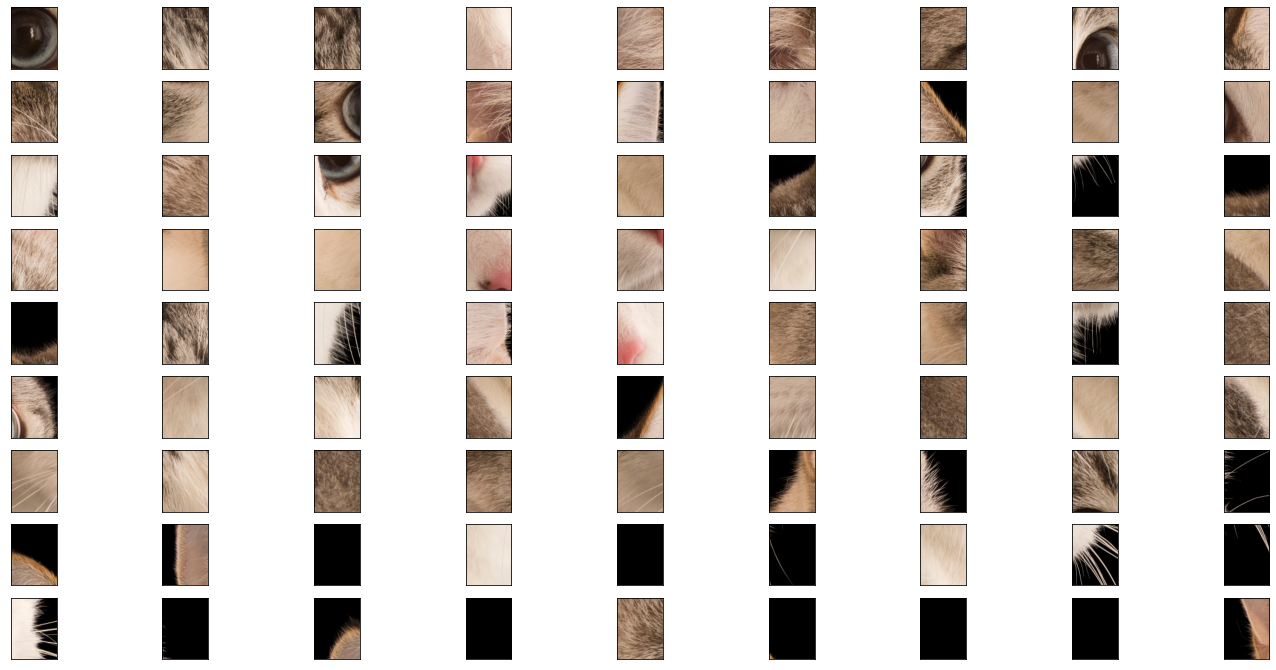

In [35]:
sara_list_sorted = sorted(sara_list, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


TypeError: Invalid shape () for image data

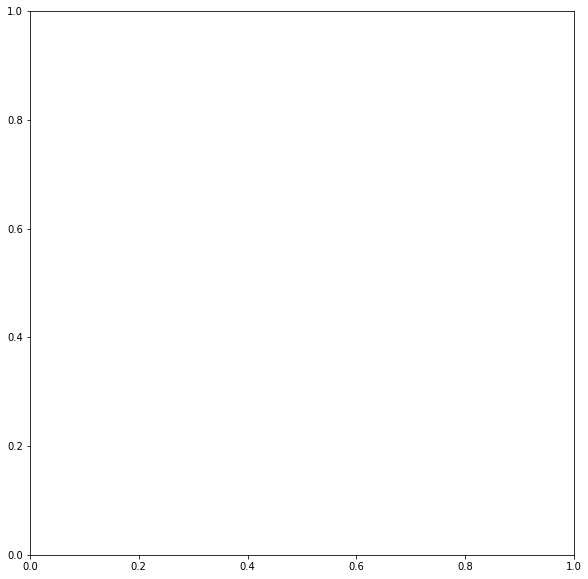

In [15]:
# Show the top 10 highest ranked segments
for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.imshow(sara_list[i][1])
    plt.xticks([]), plt.yticks([])
    plt.show()

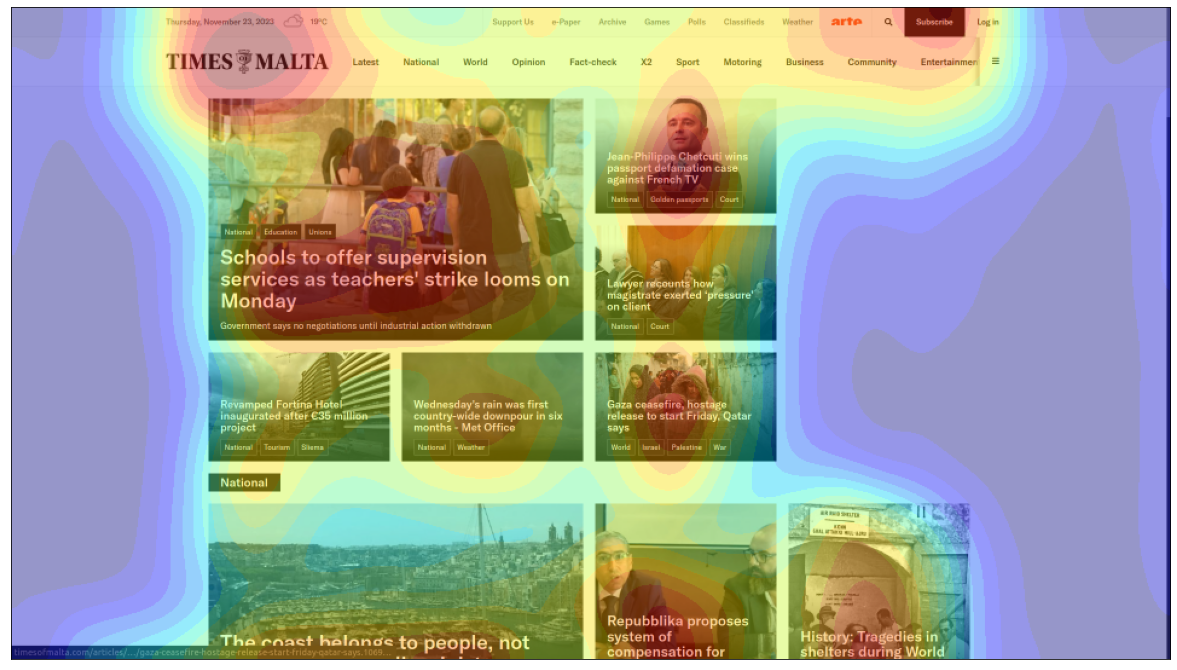

In [ ]:
fig = plt.figure()
fig.set_size_inches(24, 12)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=1)
# plt.imshow(saliency_map, alpha=0.05, cmap='flag')
plt.imshow(saliency_map, alpha=0.4, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.tight_layout
plt.show()

In [ ]:
img = cv2.imread(im)
# double size
img = cv2.resize(img, (0, 0), fx=2, fy=2)
sara.reset()
sara.WEIGHTS = (1, 1, 1)
heatmap, sara_list = sara.return_sara(img, 10, generator='deepgaze', DEVICE='cpu')
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

TypeError: return_sara() got an unexpected keyword argument 'DEVICE'

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.figure()
plt.imshow(heatmap)
plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'heatmap' is not defined

<Figure size 864x432 with 0 Axes>

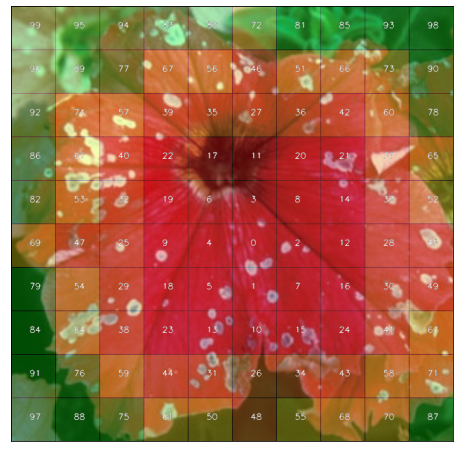

In [ ]:
plt.rcParams['figure.figsize'] = [24, 8]
plt.figure()
plt.imshow(heatmap)
plt.xticks([])
plt.yticks([])
plt.show()

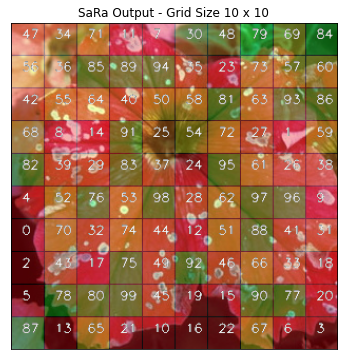

In [ ]:
sara.reset()
plot_heatmap(im, 10, name)

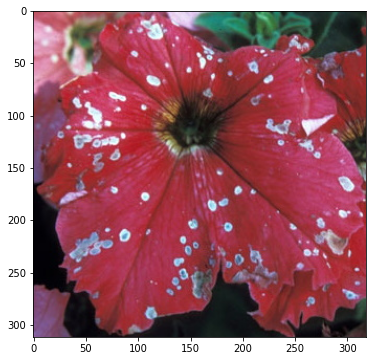

In [ ]:
im = cv2.imread(path + name)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)